# Version 01.1: Exploration

In this notebook I'm going to focus on getting to know this new dataset and to gain some intuition about how to interpret the various features as well as impute their missing values.

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
train = pd.read_csv('data/train.csv')
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Some Summary Numbers
First, just want to have a quick look to see how many missing values we're dealing with in the training set, how big it is, how many unfortunate passengers were transported to another dimension, that sort of thing.

In [2]:
print("Dataset size: {}".format(train.shape))

Dataset size: (8693, 14)


In [3]:
pd.DataFrame({
    "Missing Values (Count)": train.isna().sum(),
    "Missing Values (as Percentage)": train.isna().sum() / len(train)
})

,Missing Values (Count),Missing Values (as Percentage)
PassengerId,0,0.000000
HomePlanet,201,0.023122
CryoSleep,217,0.024963
Cabin,199,0.022892
Destination,182,0.020936
Age,179,0.020591
VIP,203,0.023352
RoomService,181,0.020821
FoodCourt,183,0.021051
ShoppingMall,208,0.023927


In [4]:
print("Transported?")
print("{:,} passengers ({:.2f}%) were transported to an alternate dimension".format(
    train['Transported'].sum(), train['Transported'].sum() / len(train) * 100))

Transported?
4,378 passengers (50.36%) were transported to an alternate dimension


Quick takeaways:
<ul>
    <li>With almost 9,000 observations, this dataset is much bigger than, for instance, the Titanic dataset.</li>
    <li>We have missing values to deal with for every feature, but only about 2% of each feature's values are missing, so we should be able to impute those using one method or another. </li>
    <li>About half the passengers in the training set were transported to an alternet dimension. Man! Tough luck.</li>
</ul>

Let's go through each feature one by one and try to gain some intuition about why.

## `PassengerId`

> A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

Now, without knowing much about this particular interdimensional mishap, my assumption is that whether or not a passenger was accidentally transported into another dimension might have something to do with where s/he was at the time of collision. However, perhaps the size of a passenger's party nevertheless has some affect, as it does with the regular Titanic. I'll create a new feature to describe party size, then, and see what's going on.

In [5]:
train['group'] = train['PassengerId'].str[:4]
train['groupsize'] = train.groupby('group')['PassengerId'].transform('count')

train[['PassengerId', 'group', 'groupsize']].head(10)

,PassengerId,group,groupsize
0,0001_01,0001,1
1,0002_01,0002,1
2,0003_01,0003,2
3,0003_02,0003,2
4,0004_01,0004,1
5,0005_01,0005,1
6,0006_01,0006,2
7,0006_02,0006,2
8,0007_01,0007,1
9,0008_01,0008,3


Now that we have a group size feature, let's group by that feature and see how it correlates with tranportation rate:

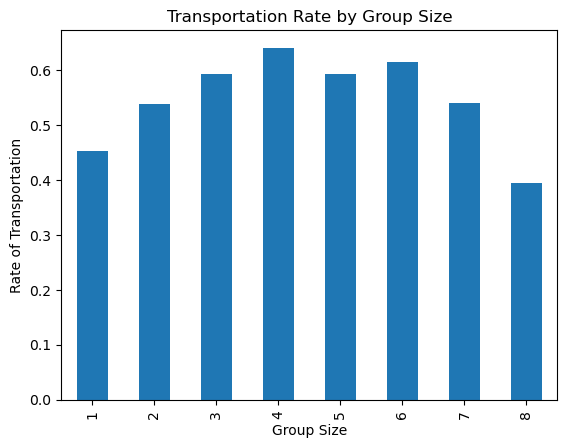

In [6]:
train.groupby('groupsize')['Transported'].mean().plot(kind='bar')
plt.xlabel('Group Size')
plt.ylabel('Rate of Transportation')
plt.title('Transportation Rate by Group Size');

We can see that medium- and larger-sized groups (3–6 people) tended to have worse outcomes when it came to being transported to another dimension. 8-person groups fared okay for some reason, but let's look a little closer.

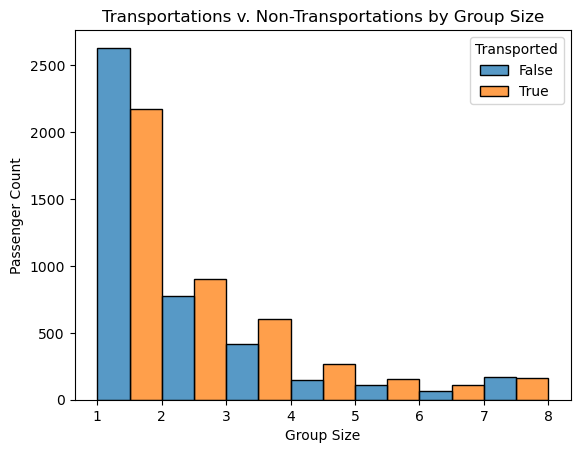

In [7]:
sns.histplot(data=train, x='groupsize', hue='Transported', multiple='dodge', binwidth=1)
plt.ylabel('Passenger Count')
plt.xlabel('Group Size')
plt.title('Transportations v. Non-Transportations by Group Size');

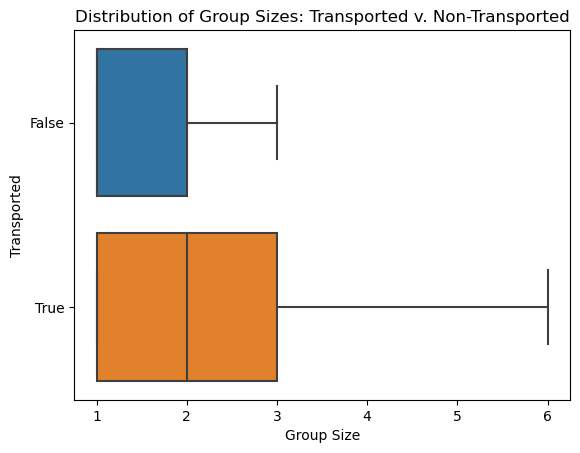

In [8]:
sns.boxplot(x=train['groupsize'], y=train['Transported'].astype('category'), showfliers=False)
plt.xlabel('Group Size')
plt.title('Distribution of Group Sizes: Transported v. Non-Transported');

This helps us get a better sense of the distribution by group size. The vast majority of passengers are traveling alone; when they're part of a group, it's a small one—two or three people; and generally passengers who were transported belonged to larger groups.

## `HomePlanet`

>The planet the passenger departed from, typically their planet of permanent residence.

At this point it's hard to imagine why home planet might affect survival rate, but let's see. Perhaps it's a proxy for class or has something to do with where passengers are on the ship.

In [9]:
train['HomePlanet'].value_counts()

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

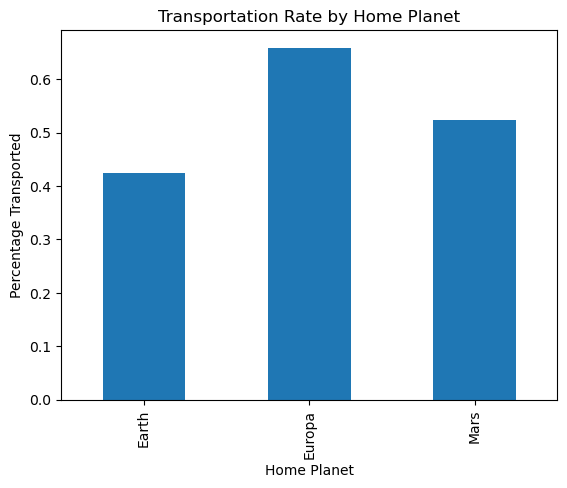

In [10]:
train.groupby('HomePlanet')['Transported'].mean().plot(kind='bar')
plt.ylabel('Percentage Transported')
plt.xlabel('Home Planet')
plt.title('Transportation Rate by Home Planet');

For whatever reason, passengers' home planets appear to correlate with transporation rates: Earthlings fare best, Europans worst, Martians in the middle. We'll return to this question later, at which point we'll be in a better position for how best to approach the missing values.

## `CryoSleep`

> Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

Intuitively this feature seems important, since our cryosleep population must have been in their cabins at the time of collision. If interdimensional transporation has anything to do with location—if it affects certain parts of the ship more than others—this feature should help us see how.

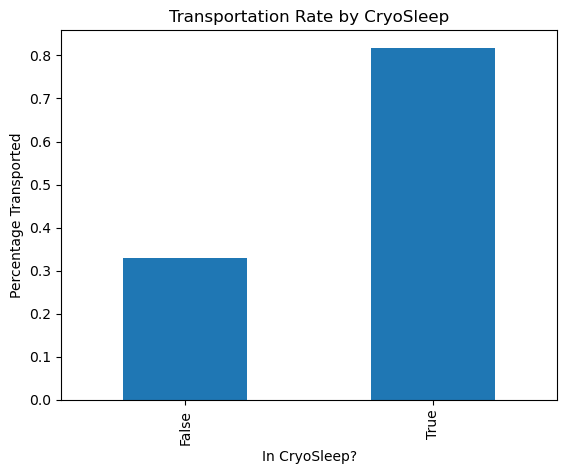

In [11]:
train.groupby('CryoSleep')['Transported'].mean().plot(kind='bar')
plt.ylabel('Percentage Transported')
plt.xlabel('In CryoSleep?')
plt.title('Transportation Rate by CryoSleep');

This is stark, so I definitely want to keep this feature in mind. Because ~80% of passengers in cryosleep (and thus confined to their cabins) were transported, my hypothesis is that the affects of the transportation event may have been focused on particular parts of the ship--perhaps those where cabins tended to be concentrated. `Cabin` happens to be the next feature, so I'll consider this question in the next section.

## `Cabin`
>The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for <i>Port</i> or S for <i>Starboard</i>.

In [12]:
train['Cabin'].head()

0    B/0/P
1    F/0/S
2    A/0/S
3    A/0/S
4    F/1/S
Name: Cabin, dtype: object

We have a little wrangling to do here. I'll separate out the various components so we can dig deeper.

In [13]:
train[['cabin_deck', 'cabin_num', 'cabin_side']] = (
    pd.DataFrame(
        train['Cabin']
        .fillna('?/?/?')
        .str
        .split('/')
        .tolist()
    )
    .replace('?', np.nan)
)

train[['cabin_deck', 'cabin_side']] = train[['cabin_deck', 'cabin_side']].astype('category')

train[['Cabin', 'cabin_deck', 'cabin_num', 'cabin_side']].head()

,Cabin,cabin_deck,cabin_num,cabin_side
0,B/0/P,B,0,P
1,F/0/S,F,0,S
2,A/0/S,A,0,S
3,A/0/S,A,0,S
4,F/1/S,F,1,S


This may be a slightly roundabout way of breaking out `cabin_deck`, `cabin_num`, and `cabin_side` features from the `Cabin` column, but it works. Let's see what insights may be lurking here.

### `cabin_deck`

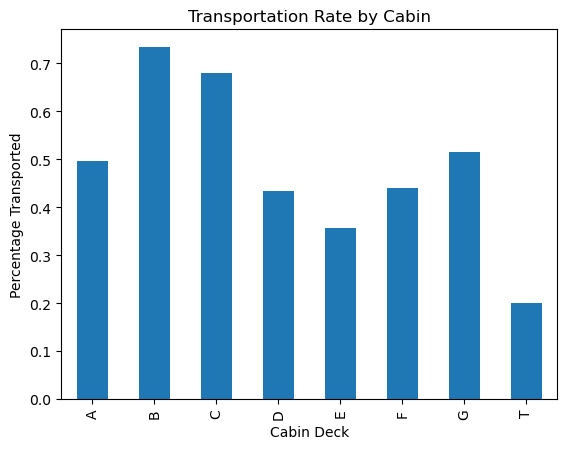

In [14]:
train.groupby('cabin_deck')['Transported'].mean().plot(kind='bar')
plt.xlabel('Cabin Deck')
plt.ylabel('Percentage Transported')
plt.title('Transportation Rate by Cabin');

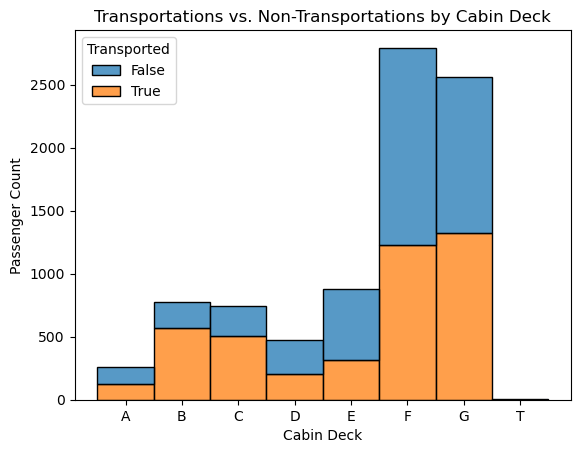

In [15]:
sns.histplot(data=train, x='cabin_deck', hue='Transported', multiple='stack')
plt.xlabel('Cabin Deck')
plt.ylabel('Passenger Count')
plt.title('Transportations vs. Non-Transportations by Cabin Deck');

Most passengers were located on F and G decks; B and C decks had the worst transportation rates.

### `cabin_num`

My hypothesis is that the cabin numbering system corresponds in some way with where cabins are located on the ship—that even-numbered cabins may be on one side, for instance, or that cabins with lower numbers may be to the fore of the ship, etc.


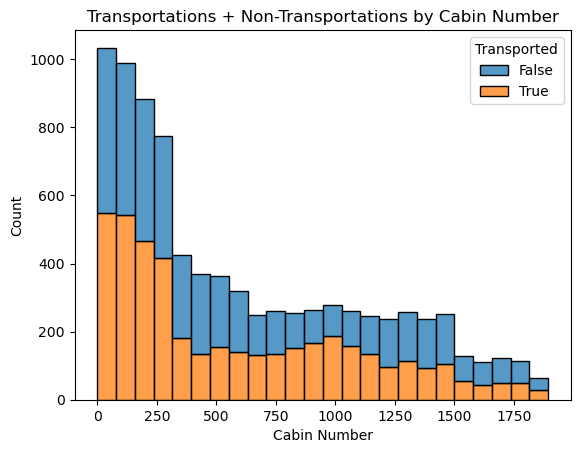

In [16]:
sns.histplot(x=train['cabin_num'].astype('float'), hue=train['Transported'], multiple='stack')
plt.xlabel('Cabin Number')
plt.ylabel('Count')
plt.title('Transportations + Non-Transportations by Cabin Number');

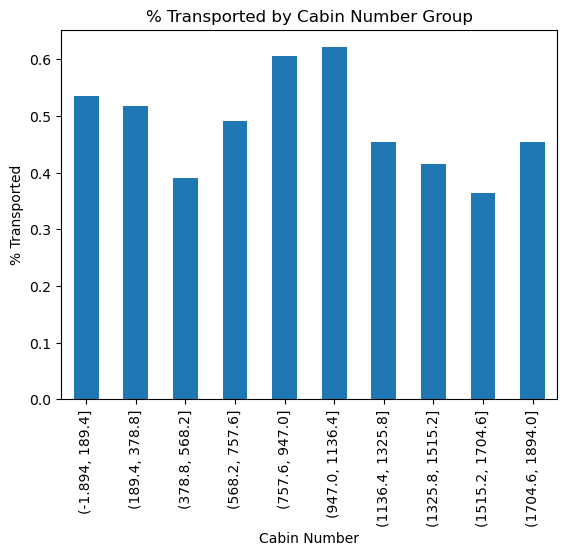

In [17]:
cabin_num = train[['cabin_num', 'Transported']].copy()
cabin_num['cabin_num_group'] = pd.cut(train['cabin_num'].astype('float'), 10)
cabin_num.groupby('cabin_num_group')['Transported'].mean().plot(kind='bar')
plt.xlabel('Cabin Number')
plt.ylabel('% Transported')
plt.title('% Transported by Cabin Number Group');

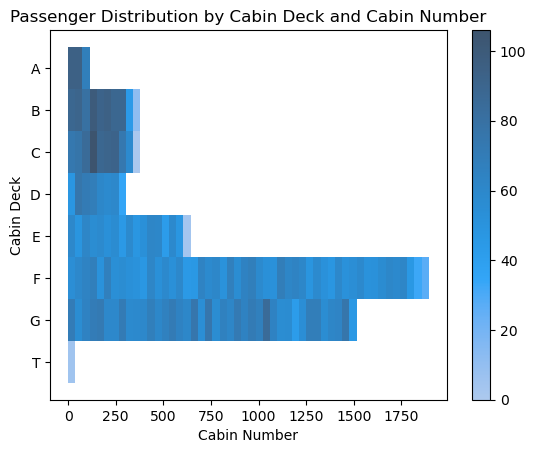

In [18]:
sns.histplot(x=train['cabin_num'].astype('float'), y=train['cabin_deck'], bins=50, cbar=True)
plt.xlabel('Cabin Number')
plt.ylabel('Cabin Deck')
plt.title('Passenger Distribution by Cabin Deck and Cabin Number');

In [19]:
train.groupby('cabin_deck')['cabin_num'].agg(['count', 'min', 'max'])

,count,min,max
cabin_deck,,,
A,256,0,99
B,779,0,99
C,747,0,99
D,478,0,99
E,876,0,99
F,2794,0,999
G,2559,0,999
T,5,0,3


Now we have a rough sense of the cabin numbering system--that there are more smaller-numbered cabins (< ~300) than larger-numbered cabins, for instance. We also have a sense for how the cabin numbering system corresponds with the deck. Deck A, for instance, has cabins numbered 0 to 107. This information will help us when it comes to imputing missing values to this feature.

### `cabin_side`

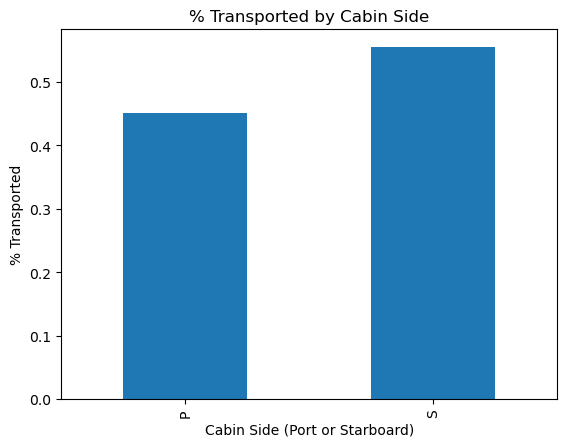

In [20]:
train.groupby('cabin_side')['Transported'].mean().plot(kind='bar')
plt.xlabel('Cabin Side (Port or Starboard)')
plt.ylabel('% Transported')
plt.title('% Transported by Cabin Side');

Seems that the port side of the ship may have fared better than the starboard side.

### Interactions between `Cabin` and `CryoSleep`

This is all useful, but if we select only the records of those passengers who were in cryosleep (and were thus confined to their cabins at the point of impact), we stand to gain some insight into whether the collision affected certain areas of the ship more so than others.

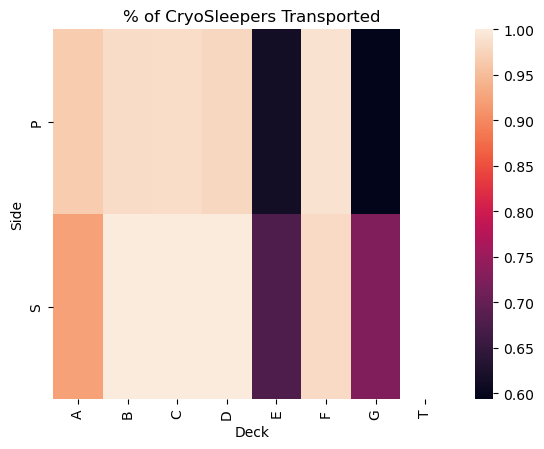

In [21]:
cryosleep = train[train['CryoSleep'] == True].copy()

g = sns.heatmap(cryosleep.groupby(['cabin_side', 'cabin_deck'])[['Transported']].mean().unstack())
plt.xlabel('Deck')
plt.ylabel('Side')
g.set_xticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])
plt.title('% of CryoSleepers Transported');

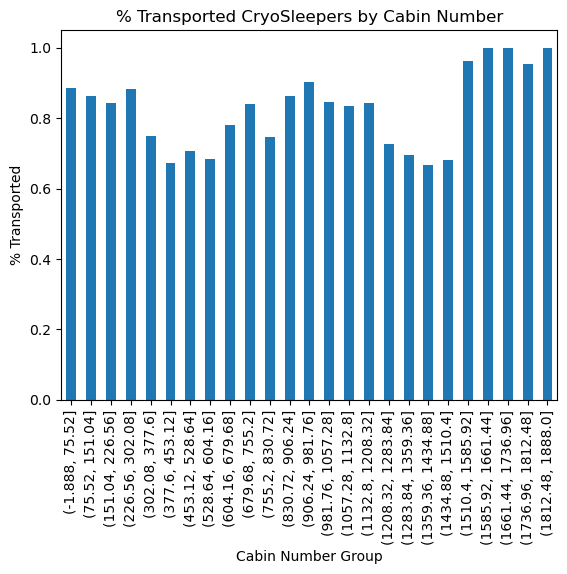

In [22]:
cryosleep['cabin_group'] = pd.cut(cryosleep['cabin_num'].astype('float'), 25)
cryosleep.groupby('cabin_group')['Transported'].mean().plot(kind='bar')
plt.xlabel('Cabin Number Group')
plt.ylabel('% Transported')
plt.title('% Transported CryoSleepers by Cabin Number');

As a reminder, cryosleepers didn't fare well to begin with—it seems that the transportation event was escapable, perhaps not unlike a sinking ship. And yet, certain decks fared especially bad for our sleeping population, while others did not. Cryosleepers on decks E and G, for example, remained in this dimension 30–40% of the time.

## `Destination`
>The planet the passenger will be debarking to.

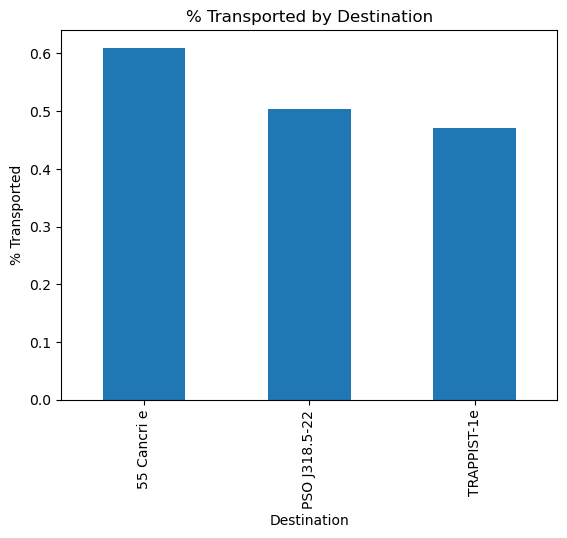

In [23]:
train.groupby('Destination')['Transported'].mean().plot(kind='bar')
plt.xlabel('Destination')
plt.ylabel('% Transported')
plt.title('% Transported by Destination');

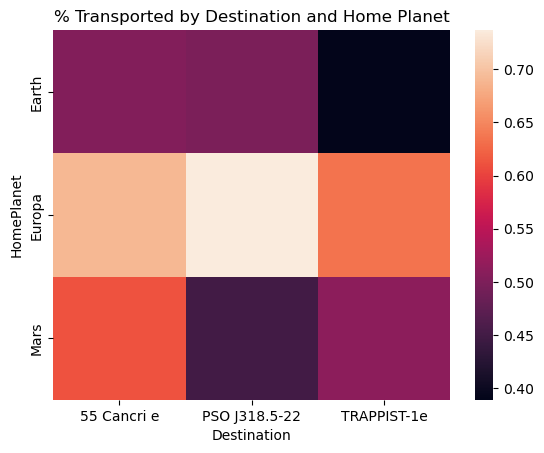

In [24]:
sns.heatmap(train.groupby(['HomePlanet', 'Destination'])['Transported'].mean().unstack())
plt.title('% Transported by Destination and Home Planet');

Like `HomePlanet`, `Destination` seems to correlate with transportation rate. Another class proxy, perhaps?

## `Age`
>The age of the passenger.

Let's start with a simpe box plot.

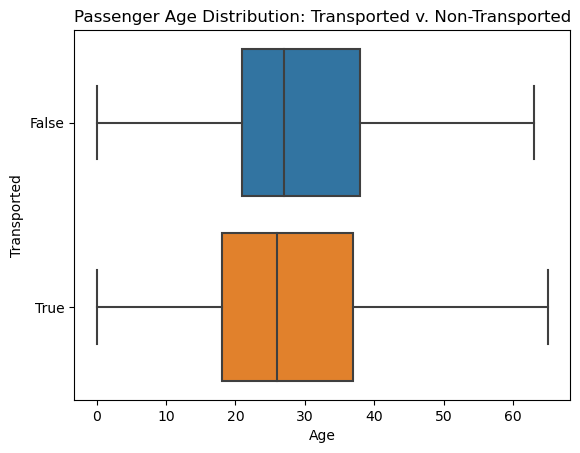

In [25]:
sns.boxplot(x=train['Age'], y=train['Transported'].astype('category'), showfliers=False)
plt.title('Passenger Age Distribution: Transported v. Non-Transported');

Seems that the age distribution of passengers who were spared transportation skews slightly older.

## `VIP`
>Whether the passenger has paid for special VIP service during the voyage.

Likely this is another proxy for class.

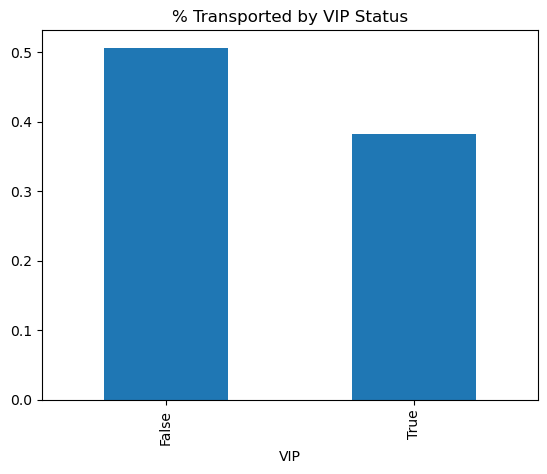

In [26]:
train.groupby('VIP')['Transported'].mean().plot(kind='bar')
plt.title('% Transported by VIP Status');

## `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`
>Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

Presumably these fields offer yet another proxy for class. Let's check. First, though, I'll create a new feature that totals all the amenities, since this combined expense field may offer a bigger overall picture of a passenger's class status.

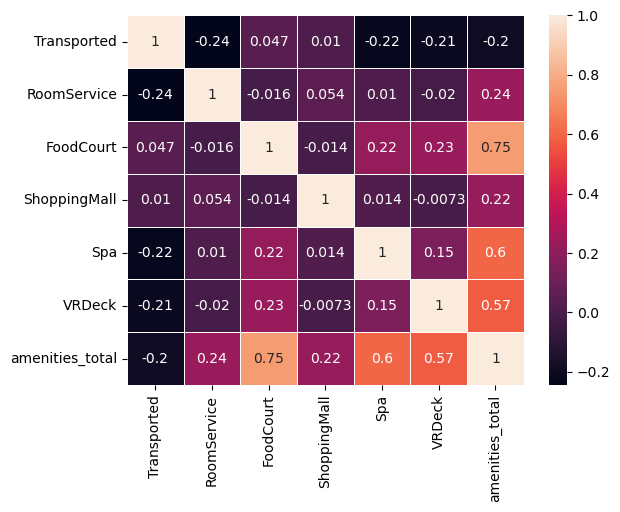

In [27]:
train['amenities_total'] = (
    train['RoomService'] 
    + train['FoodCourt'] 
    + train['ShoppingMall'] 
    + train['Spa']
    + train['VRDeck']
)

spending_cols = ['Transported', 'RoomService', 'FoodCourt','ShoppingMall','Spa','VRDeck', 'amenities_total']
sns.heatmap(train[spending_cols].corr(), annot=True, linewidth=.5);

This heatmap gives us a quick sense of how the various expense and amenity categories interact. Generally it seems that there is a negative correlation between being transported and amenity spending, seeming to confirm the hypothesis that wealthier passengers may have been spared this terrible fate. I'll confirm this intuition with a boxplot, which clearly shows that non-transported passengers tended to spend much more.

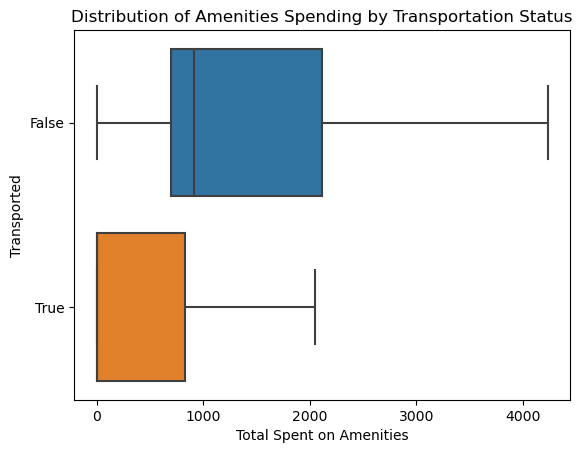

In [28]:
sns.boxplot(x=train['amenities_total'], y=train['Transported'].astype('category'), showfliers=False)
plt.xlabel('Total Spent on Amenities')
plt.title('Distribution of Amenities Spending by Transportation Status');

## `Name`
>Name - The first and last names of the passenger.

I'm wondering whether there might be any hints in passenger names. Let's have a look.

In [29]:
train['Name'].head(10)

0       Maham Ofracculy
1          Juanna Vines
2         Altark Susent
3          Solam Susent
4     Willy Santantines
5     Sandie Hinetthews
6    Billex Jacostaffey
7    Candra Jacostaffey
8         Andona Beston
9        Erraiam Flatic
Name: Name, dtype: object

Unlike the Titanic dataset, name seem to be a bit more consistent here. I'm noticing shared last names, among other things, and some consistency in the rendering of names (i.e., first and last name). Let's see if that's the case.

In [30]:
train['Name'].str.split().str.len().value_counts()

2.0    8493
Name: Name, dtype: int64

As we can see, all passenger names consist of two parts, so I can break these out into separate features for first and last name

In [31]:
train[['first_name', 'last_name']] = (
    pd.DataFrame(
        train['Name']
        .fillna('? ?')
        .str
        .split()
        .tolist()
    ).replace('?', np.nan)
)

train[['Name', 'first_name', 'last_name']].head()

,Name,first_name,last_name
0,Maham Ofracculy,Maham,Ofracculy
1,Juanna Vines,Juanna,Vines
2,Altark Susent,Altark,Susent
3,Solam Susent,Solam,Susent
4,Willy Santantines,Willy,Santantines


In [32]:
train['last_name_count'] = train.groupby('last_name')['PassengerId'].transform('count')
train['first_name_count'] = train.groupby('first_name')['PassengerId'].transform('count')
train[['Name', 'last_name_count', 'first_name_count']].head(10)

,Name,last_name_count,first_name_count
0,Maham Ofracculy,1.0,4.0
1,Juanna Vines,4.0,6.0
2,Altark Susent,6.0,1.0
3,Solam Susent,6.0,3.0
4,Willy Santantines,6.0,9.0
5,Sandie Hinetthews,7.0,4.0
6,Billex Jacostaffey,7.0,4.0
7,Candra Jacostaffey,7.0,5.0
8,Andona Beston,5.0,2.0
9,Erraiam Flatic,3.0,2.0


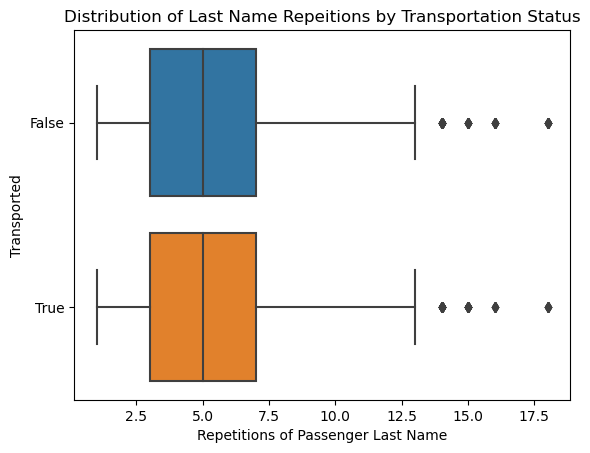

In [33]:
sns.boxplot(x=train['last_name_count'], y=train['Transported'].astype('category'))
plt.xlabel('Repetitions of Passenger Last Name')
plt.title('Distribution of Last Name Repeitions by Transportation Status');

The above chart suggests that the number of times a passenger's last name appears on the ship manifest does not correlate meaningfully with whether or not a passenger was transported.

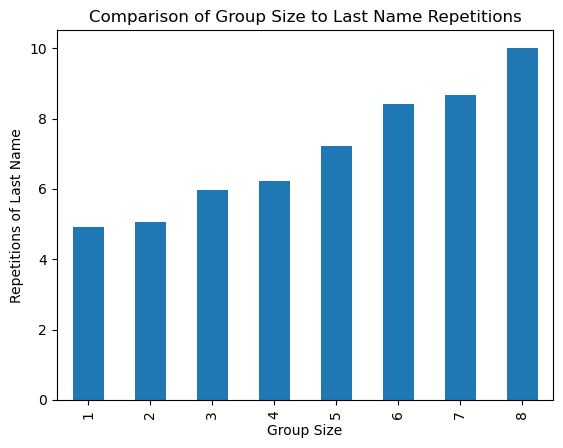

In [34]:
train.groupby('groupsize')['last_name_count'].mean().plot(kind='bar')
plt.xlabel('Group Size')
plt.ylabel('Repetitions of Last Name')
plt.title('Comparison of Group Size to Last Name Repetitions');

And yet, predictably, group size and last name reptitions do correlate--passengers traveling as parts of larger groups tend to have more commonly repeated last names, which makes sense considering that groups may often be families.

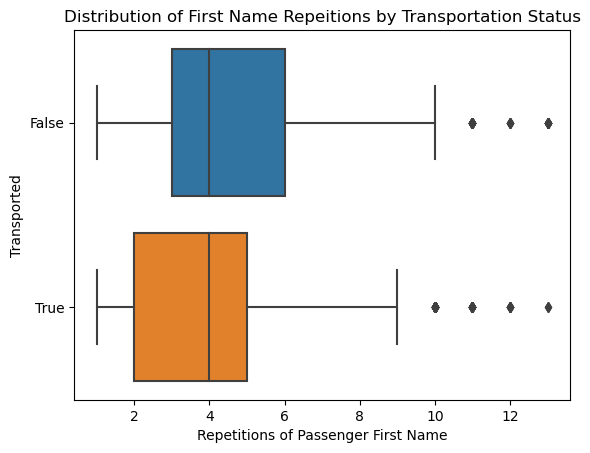

In [35]:
sns.boxplot(x=train['first_name_count'], y=train['Transported'].astype('category'))
plt.xlabel('Repetitions of Passenger First Name')
plt.title('Distribution of First Name Repeitions by Transportation Status');

Interestingly, first name repetitions are distributed differently for transported vs. non-transported passengers: for whatever reason, passengers with more popular first names were transported less frequently than those with less popular names.